In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD

### **Load data**

In [48]:
#Reading user file:
u_cols =  ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('./data/ml-100k/u.user', sep='|', names=u_cols, encoding='latin-1')

n_users = users.shape[0]
print('Number of users:', n_users)
users.head() #uncomment this to see some few examples

Number of users: 943


,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [49]:
#Reading ratings file:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

rate_train = pd.read_csv('./data/ml-100k/ua.base', sep='\t', names=r_cols, encoding='latin-1')
rate_test = pd.read_csv('./data/ml-100k/ua.test', sep='\t', names=r_cols, encoding='latin-1')

# rate_train = ratings_base.as_matrix()
# rate_test = ratings_test.as_matrix()

print('Number of traing rates:', rate_train.shape[0])
print('Number of test rates:', rate_test.shape[0])

Number of traing rates: 90570
Number of test rates: 9430


In [50]:
print(rate_train.head())
print(rate_test.head())

   user_id  movie_id  rating  unix_timestamp
0        1         1       5       874965758
1        1         2       3       876893171
2        1         3       4       878542960
3        1         4       3       876893119
4        1         5       3       889751712
   user_id  movie_id  rating  unix_timestamp
0        1        20       4       887431883
1        1        33       4       878542699
2        1        61       4       878542420
3        1       117       3       874965739
4        1       155       2       878542201


(array([1]), [Text(1, 0, '1')])

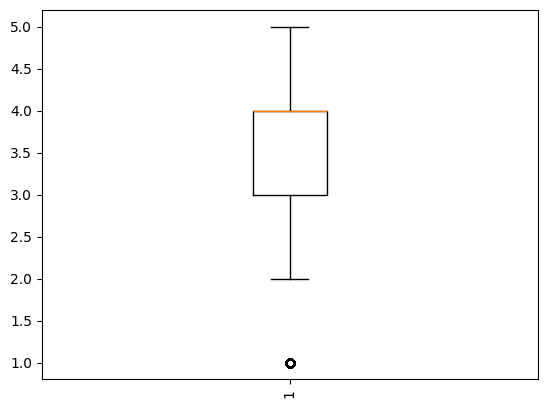

In [51]:
plt.boxplot(rate_train['rating'])
plt.xticks(rotation=90)

### **Establish item profiles**

In [52]:
#Reading items file:
i_cols = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure', 
        'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 
        'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

items = pd.read_csv('./data/ml-100k/u.item', sep='|', names=i_cols, encoding='latin-1')

n_items = items.shape[0]
print('Number of items:', n_items)
items.head(3)

Number of items: 1682


,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


* #### *Mark the genres that the films belongs*

In [53]:
item_counter = items.iloc[:,5:]
item_counter

,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1678,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1679,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1680,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


* #### Erect the TF-IDF matrix for the importance percentage of each word in a film

In [54]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA

In [55]:
transformer = TfidfTransformer(smooth_idf=True, norm ='l2')
tfidf = transformer.fit_transform(item_counter).toarray()

* #### Reduce dimension by PCA

In [56]:
pca = PCA(n_components = 10)
tfidf_pca = pca.fit_transform(tfidf)

In [57]:
print(tfidf_pca.shape)
tfidf_pca

(1682, 10)


array([[-0.35, -0.02, -0.1 , ..., -0.14, -0.19,  0.19],
       [-0.22,  0.66, -0.19, ..., -0.13, -0.02, -0.11],
       [-0.17,  0.55, -0.16, ...,  0.02, -0.01,  0.03],
       ...,
       [ 0.27, -0.03,  0.77, ..., -0.04, -0.02, -0.04],
       [-0.64, -0.55, -0.18, ...,  0.01,  0.01, -0.01],
       [ 0.72, -0.19, -0.07, ..., -0.  , -0.01, -0.02]])

* #### Reduce dimension by removing high-correlated columns

In [58]:
tfidf_df = pd.DataFrame(tfidf)
tfidf_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.0,0.000000,0.00000,0.74066,0.573872,0.349419,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.536767,0.65097,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.536767,0.0,0.0
2,0.0,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0
3,0.0,0.710652,0.00000,0.00000,0.000000,0.539759,0.000000,0.0,0.451259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.000000,0.00000,0.00000,0.000000,0.000000,0.735504,0.0,0.363186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.571953,0.0,0.0


<Axes: >

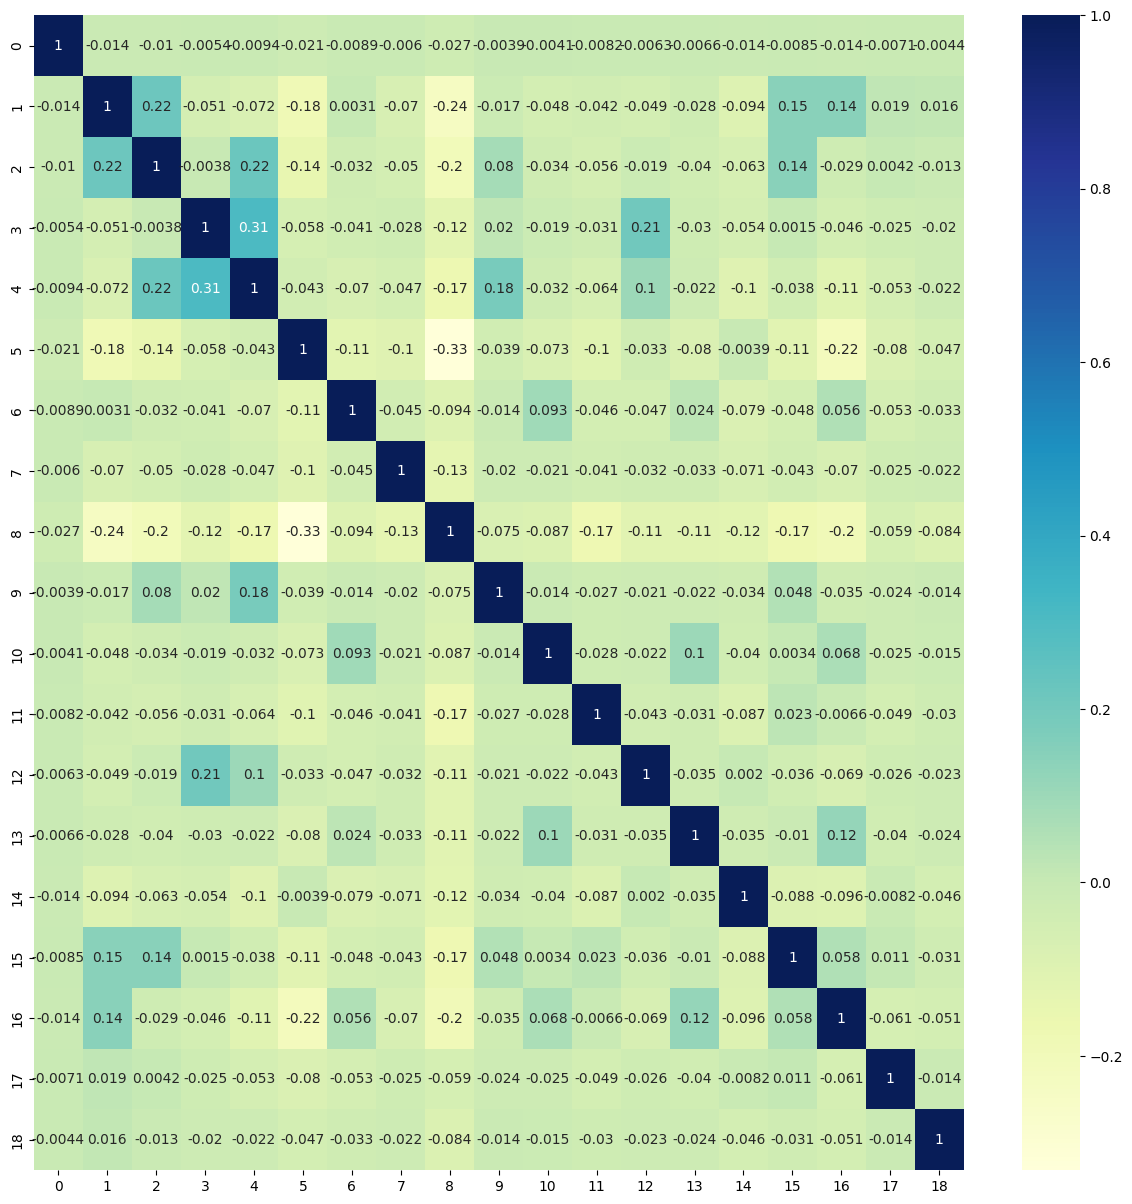

In [59]:
plt.figure(figsize=(15,15))
sns.heatmap(tfidf_df.corr(), cmap="YlGnBu", annot=True) 

* Because of high-level correlation, I decide to remove these columns: Adventure, Animation, Action

In [60]:
tfidf_df.drop(columns=[1,2,3,6,10,16], inplace=True)

In [61]:
tfidf_corr = tfidf_df.to_numpy()
tfidf_corr.shape

(1682, 13)

### **Build the recommender model by using the predicted rating of users**

In [62]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

In [63]:
class ContentBasedWithRating():
    def __init__(self, tfidf:TfidfTransformer, n_users) -> None:
        self.tfidf = tfidf
        self.d = tfidf.shape[1]
        self.W = np.zeros((self.d, n_users))
        self.b = np.zeros((1, n_users))
        self.Yhat = None
    
    def get_items_rated_by_user(self, rate_matrix, user_id) -> tuple:
        """
        in each line of rate_matrix, we have infor: user_id, item_id, rating (scores), time_stamp
        we care about the first three values
        return (item_ids, scores) rated by user user_id
        """
        y = rate_matrix.iloc[:,0] # all users
        
        ids = np.where(y == user_id)[0] # users = user_id
        item_ids = rate_matrix.iloc[ids, 1] # movie_ids of user_id
        scores = rate_matrix.iloc[ids, 2] # rates of those movie_ids
        return item_ids, scores

    def fit_transform(self, rate_train:iter, n_users:int, lamda=3):
        for n in range(1, n_users+1):    
            ids, scores = self.get_items_rated_by_user(rate_train, n)   # choose the movie_ids and scores of rated movies by user_n
            
            clf = Ridge(alpha=lamda, fit_intercept = True)   # Predict rating of this user by the linear model + regularization
            Xhat = self.tfidf[ids-1, :]  # choose the feature vectors of movies were rated by user_n
            clf.fit(Xhat, scores)
            
            self.W[:, n-1] = clf.coef_ # user profile: (n_movies, user-n)
            self.b[0, n-1] = clf.intercept_
        
        # Predict the whole users' rating for each film which is Utility matrix
        self.Yhat = abs(self.tfidf.dot(self.W) + self.b)
            
    def predict(self, user_id:int, rate_test:iter, Yhat) -> tuple:      
        np.set_printoptions(precision=2) # 2 digits after . 
        movie_ids, scores = self.get_items_rated_by_user(rate_test, user_id)
        print('Rated movies ids :', movie_ids.to_list())
        print('True ratings     :', scores.to_list())
        print('Predicted ratings:', Yhat[movie_ids-1, user_id-1])
        # Plotting linear regression of rate_test and predicts
        sns.regplot(x=Yhat[movie_ids-1, user_id-1], y=scores)
        plt.xlabel('Predicted scores')
        plt.ylabel('Actual scores')
        
        return movie_ids.to_list(), Yhat[movie_ids-1, user_id-1]
    
    def predict_all(self, rates:iter, n_users:int):
        users, ids, reals, preds = [], [], [], []
        for n in range(1, n_users+1):
            movie_ids, scores_truth = self.get_items_rated_by_user(rates, n)
            scores_pred = self.Yhat[movie_ids-1, n-1]
            # Aggerate the performance info
            ids += movie_ids.to_list()
            users += [n for i in range(len(movie_ids.to_list()))]
            reals += scores_truth.to_list()
            preds += scores_pred.tolist()
        
        df = pd.DataFrame({'movie_id':ids, 'user_id':users, 
                           'real':reals, 'predict':preds})
        return df
            
    def RMSE(self, rates:iter) -> float:
        se, cnt = 0.0, 0
        for n in range(1, n_users+1):
            ids, scores_truth = self.get_items_rated_by_user(rates, n)
            scores_pred = self.Yhat[ids-1, n-1]        
            # Calculate sigma of the squared differences
            e = scores_truth - scores_pred 
            se += (e*e).sum(axis = 0)
            cnt += e.size 

        return np.sqrt(se/cnt)
    
    def r2_score(self, rates:iter, n_users:int) -> float:
        users, ids, reals, preds = [], [], [], []
        for n in range(1, n_users+1):
            movie_ids, scores_truth = self.get_items_rated_by_user(rates, n)
            scores_pred = self.Yhat[movie_ids-1, n-1]
            # Aggerate the performance info
            try:
                ids += movie_ids.to_list()
                users += [n for i in range(len(movie_ids.to_list()))]
                reals += scores_truth.to_list()
                preds += scores_pred.tolist()
            except Exception as ex:
                pass
        
        r2 = r2_score(reals, preds)
        return r2
    
def recommend(items, user_id, Yhat) -> tuple:
    return items['movie id'], Yhat[items['movie id']-1, user_id-1]

In [64]:
def search_regularization(model, train, test, users, parameters):
    mse = []
    for learning_rate in parameters:
        model.fit_transform(train, users, lamda=learning_rate)
        mse.append(model.RMSE(test))
    
    print(mse)
    sns.lineplot(x=parameters, y=mse)

In [65]:
recommender = ContentBasedWithRating(tfidf=tfidf, n_users=n_users)
recommender_pca = ContentBasedWithRating(tfidf=tfidf_pca, n_users=n_users)
recommender_corr = ContentBasedWithRating(tfidf=tfidf_corr, n_users=n_users)

In [66]:
parameters = [5, 7, 9, 11, 13, 15, 17]

# search_regularization(recommender, rate_train, rate_test, n_users, parameters)
# search_regularization(recommender_pca, rate_train, rate_test, n_users, parameters)
# search_regularization(recommender_corr, rate_train, rate_test, n_users, parameters)

In [67]:
recommender.fit_transform(rate_train, n_users, lamda=7)
recommender_pca.fit_transform(rate_train, n_users, lamda=7)
recommender_corr.fit_transform(rate_train, n_users, lamda=7)

Testing prediction on one user

Rated movies ids : [20, 33, 61, 117, 155, 160, 171, 189, 202, 265]
True ratings     : [4, 4, 4, 3, 2, 4, 5, 3, 5, 4]
Predicted ratings: [4.05 3.49 4.08 3.1  3.44 4.08 4.06 3.26 3.76 3.3 ]


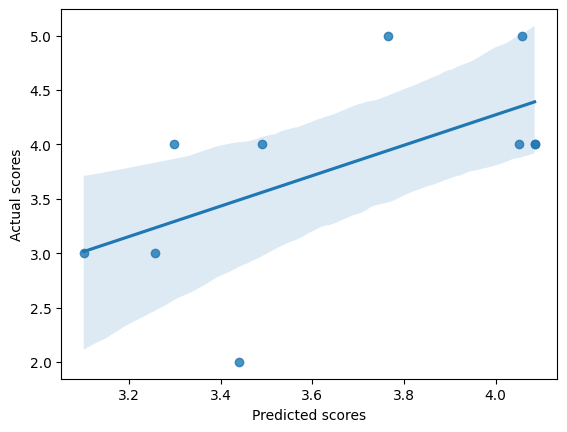

In [68]:
_, y_pred_test = recommender_pca.predict(1, rate_test, recommender_pca.Yhat)
_, y_true_test = recommender_pca.get_items_rated_by_user(rate_test, 1)

In [69]:
print('R2 for testing', r2_score(y_pred=y_pred_test, y_true=y_true_test))
print('MSE for testing', mean_squared_error(y_pred=y_pred_test, y_true=y_true_test))

R2 for testing 0.2982734338402663
MSE for testing 0.5333121902813975


#### Evaluate the model

In [82]:
print('After remaining origin dimension: ')
print('-> RMSE for testing', recommender.RMSE(rate_test))
print('-> R2-score for testing', recommender.r2_score(rate_test, n_users))
print('\n')
print('After applying PCA for reducing dimensions (n_component=10): ')
print('-> RMSE for testing', recommender_pca.RMSE(rate_test))
print('-> R2-score for testing', recommender_pca.r2_score(rate_test, n_users))
print('\n')
print('After removing high-correlated columns for reducing dimensions: ')
print('-> RMSE for testing', recommender_corr.RMSE(rate_test))
print('-> R2-score for testing', recommender_corr.r2_score(rate_test, n_users))

After remaining origin dimension: 
-> RMSE for testing 1.024520792639543
-> R2-score for testing 0.1635002570264923


After applying PCA for reducing dimensions (n_component=10): 
-> RMSE for testing 1.0250230776033122
-> R2-score for testing 0.16267984568699578


After removing high-correlated columns for reducing dimensions: 
-> RMSE for testing 1.0277717169274092
-> R2-score for testing 0.15818321156744408


In [71]:
result_pca = recommender_pca.predict_all(rate_test, n_users)
result_pca

,movie_id,user_id,real,predict
0,20,1,4,4.050763
1,33,1,4,3.491380
2,61,1,4,4.084941
3,117,1,3,3.101625
4,155,1,2,3.439621
...,...,...,...,...
9425,232,943,4,3.325851
9426,356,943,4,3.746044
9427,570,943,1,3.403861
9428,808,943,4,3.849616


<Axes: >

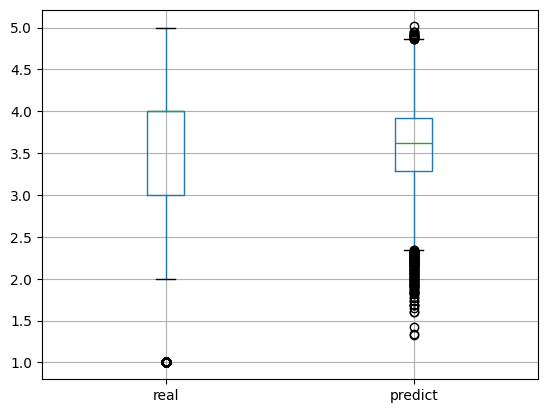

In [72]:
result_pca[['real','predict']].boxplot()

C:\Users\buidu\AppData\Local\Temp\ipykernel_2432\4047187210.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(result_pca['real'], hist=False, color='red', label='Actual value')
C:\Users\buidu\AppData\Local\Temp\ipykernel_2432\4047187210.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe57

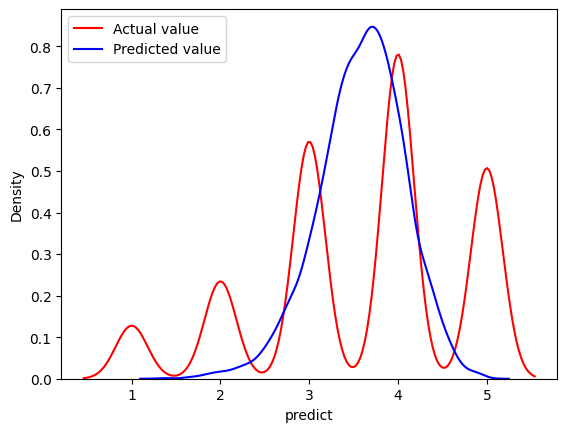

In [73]:
ax1 = sns.distplot(result_pca['real'], hist=False, color='red', label='Actual value')
ax2 = sns.distplot(result_pca['predict'], hist=False, color='blue', label='Predicted value', ax=ax1)
plt.legend()

### **Dump Yhat to csv file**

In [74]:
# np.savetxt('./artificats/recommends_pca.csv', recommender.Yhat, delimiter=',')

In [75]:
Yhat = np.loadtxt('./artificats/recommends.csv', delimiter=',')

In [76]:
print('Ma trận Utility giữa movie và user:', Yhat.shape)
Yhat

Ma trận Utility giữa movie và user: (1682, 943)


array([[2.46, 3.31, 1.13, ..., 5.05, 4.08, 2.7 ],
       [2.73, 4.65, 2.72, ..., 2.45, 4.4 , 3.62],
       [3.57, 2.96, 2.22, ..., 5.42, 4.12, 3.76],
       ...,
       [4.12, 4.09, 2.96, ..., 5.73, 4.63, 3.49],
       [3.59, 3.57, 3.21, ..., 3.81, 3.84, 2.73],
       [4.03, 3.67, 3.25, ..., 5.74, 4.46, 3.81]])

In [77]:
def recommend(items, user_id, Yhat):
    return Yhat[items['movie id']-1, user_id-1]

In [78]:
# sorted(recommend(items, 1, Yhat).tolist(), reverse=True)